In [74]:
import os
import pandas as pd
import numpy as np
import random

from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, recall_score, f1_score

import torch
from torch import nn, optim
import torch.nn.functional as F

from vocabulary import Vocabulary
from dataset import Dataset, collate_fn
from models import Classifier

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Menlo"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams.update({'font.size': 22})

from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Import data

Read files

In [3]:
activity = pd.read_csv('clean/activity_clean.csv')
hemolysis = pd.read_csv('clean/hemolysis_clean.csv')

Get vocabulary

In [4]:
vocabulary = Vocabulary.get_vocabulary_from_sequences(activity['sequence'].values)

#### Define RNN functions

Helper functions

In [5]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return category_i

def nan_equal(a,b):
    try:
        np.testing.assert_equal(a,b)
    except AssertionError:
        return False
    return True

def models_are_equal(model1, model2):
    model1.vocabulary == model2.vocabulary
    model1.hidden_size == model2.hidden_size
    for a,b in zip(model1.model.parameters(), model2.model.parameters()):
        if nan_equal(a.detach().numpy(), b.detach().numpy()) == True:
            print("true")

#### Train RNNs

Define training functions

In [6]:
def training(model, test_dataloader, training_dataloader, n_epoch, optimizer, filename, logname):
    
    roc_training = []
    roc_test = []
    
    for e in tqdm(range(1, n_epoch + 1)):

        for i_batch, sample_batched in enumerate(training_dataloader):
            seq_batched = sample_batched[0][0].to(model.device, non_blocking=True)
            seq_lengths = sample_batched[0][1].to(model.device, non_blocking=True)
            cat_batched = sample_batched[1].to(model.device, non_blocking=True)

            output = model.evaluate(seq_batched, seq_lengths)
            
            log_probs = F.log_softmax(output, dim=1)
            loss = nn.NLLLoss()(log_probs, cat_batched)

            optimizer.zero_grad()
            loss.backward()  
            torch.nn.utils.clip_grad_value_(model.model.parameters(), 2)
            optimizer.step()

        model.save(filename.format(e))
        
        def _evaluate_ROC(data_loader):
            cat_list = []
            out_list = []

            with torch.no_grad():
                for i_batch, sample_batched in enumerate(data_loader):    
                    seq_batched = sample_batched[0][0].to(model.device, non_blocking=True)
                    seq_lengths = sample_batched[0][1].to(model.device, non_blocking=True)
                    
                    cat_list += sample_batched[1].to("cpu", non_blocking=True)
                    out_list += torch.exp(model.evaluate(seq_batched, seq_lengths))[: ,1].to("cpu", non_blocking=True)

                cat_list = torch.stack(cat_list)
                out_list = torch.stack(out_list)

                roc = roc_auc_score(cat_list.cpu().numpy().astype(int), out_list.cpu().numpy())
            return roc
        
        roc_tr = _evaluate_ROC(training_dataloader)
        roc_te = _evaluate_ROC(test_dataloader)
        roc_training.append(roc_tr)
        roc_test.append(roc_te)

        with open(logname, 'a') as f:
            f.write('{},{}\n'.format(roc_tr, roc_te))

        if roc_tr == 1.0:
            break
        
    return model, optimizer, roc_training, roc_test

def train_splits(df, purpose, n_embedding, n_hidden, n_layers, learning_rate, momentum, batch_size, n_epoch):

    for i in range(1, 6):

        # Create model directory
        if not os.path.exists('models/RNN_{}/split_{}'.format(purpose, i)):
            os.makedirs('models/RNN_{}/split_{}'.format(purpose, i))
        
        # Write log file 
        with open('models/RNN_{}/split_{}/log.txt'.format(purpose, i), 'w') as f:
            f.write('n_embedding: {}\n'.format(n_embedding))
            f.write('n_hidden: {}\n'.format(n_hidden))
            f.write('n_layers: {}\n'.format(n_layers))
            f.write('learning_rate: {}\n'.format(learning_rate))
            f.write('momentum: {}\n'.format(momentum))
            f.write('batch_size: {}\n'.format(batch_size))
            f.write('n_epoch: {}\n'.format(n_epoch))
            f.write('\n')
            f.write('Training ROC-AUC,Test ROC-AUC\n')

        # Initialize data splits
        train = Dataset(df[df[f'split_{i}'] == 'training'], vocabulary)
        test = Dataset(df[df[f'split_{i}'] == 'test'], vocabulary)

        # Initialize the model
        model = Classifier(n_embedding, n_hidden, n_layers, vocabulary)
        model.to(device)

        # Initialize the optimizer
        optimizer = optim.SGD(model.model.parameters(), lr = learning_rate, momentum=momentum)

        # Load the data
        training_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn = collate_fn, drop_last=True, pin_memory=True, num_workers=8)
        test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True, collate_fn = collate_fn, drop_last=True, pin_memory=True, num_workers=8)

        # Define model name
        filename = 'models/RNN_{}/split_{}/em{}_hi{}_la{}_ep{{}}'.format(purpose, i, n_embedding, n_hidden, n_layers)
        logname = 'models/RNN_{}/split_{}/log.txt'.format(purpose, i)

        # Train the model
        model, optimizer, roc_training, roc_test = training(model, test_dataloader, training_dataloader, n_epoch, optimizer, filename, logname)

Train model: Activity

In [ ]:
n_embedding  = 100
n_hidden = 400
n_layers = 2
n_epoch = 150
learning_rate = 0.01
momentum = 0.9
batch_size = 20

train_splits(activity, 'activity', n_embedding, n_hidden, n_layers, learning_rate, momentum, batch_size, n_epoch)

Train model: Hemolysis

In [ ]:
n_embedding  = 100
n_hidden = 400
n_layers = 1
n_epoch = 150
learning_rate = 0.01
momentum = 0.9
batch_size = 20

train_splits(hemolysis, 'hemolysis', n_embedding, n_hidden, n_layers, learning_rate, momentum, batch_size, n_epoch)

#### Evaluate RNNs

Determine best model for each split

In [18]:
def plot_roc_curves(path, n_splits):
    
    roc_training = []
    roc_test = []
    colors = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
    
    for i in range(1, n_splits + 1):
        log = pd.read_csv(f'models/RNN_{path}/split_{i}/log.txt', skiprows=[0, 1, 2, 3, 4, 5, 6, 7])
        roc_training.append(log['Training ROC-AUC'])
        roc_test.append(log['Test ROC-AUC'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6.5), sharey=True)
    for i in range(n_splits):
        ax1.plot(roc_training[i], label=f'Split {i+1}', color=colors[i])
        ax2.plot(roc_test[i], label=f'Split {i+1}', color=colors[i]) 
    
    ax1.set_xlim(0, 150)
    ax2.set_xlim(0, 150)
    ax1.set_ylim(0, 1.05)
    ax2.set_ylim(0, 1.05)

    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')
    ax1.set_ylabel('ROC-AUC')
    
    ax1.set_title('Training ROC')
    ax2.set_title('Test ROC')
    ax2.legend(loc='lower center', bbox_to_anchor=(1.275, 0.225))
    
    plt.savefig(f'figures/RNN_{path}_ROC.png', dpi=1200, bbox_inches='tight')

def determine_best_models(path, n_splits):
    
    best_epochs = []
    for i in range(1, n_splits + 1):
        log = pd.read_csv(f'models/RNN_{path}/split_{i}/log.txt', skiprows=[0, 1, 2, 3, 4, 5, 6, 7])
        best_epochs.append(log['Test ROC-AUC'].idxmax() + 1)
    
    best_models = []
    for i in range(1, n_splits + 1):
        if path == 'activity':
            best_models.append(f'models/RNN_{path}/split_{i}/em100_hi400_la2_ep{best_epochs[i-1]}')
        elif path == 'hemolysis':
            best_models.append(f'models/RNN_{path}/split_{i}/em100_hi400_la1_ep{best_epochs[i-1]}')
    return best_models

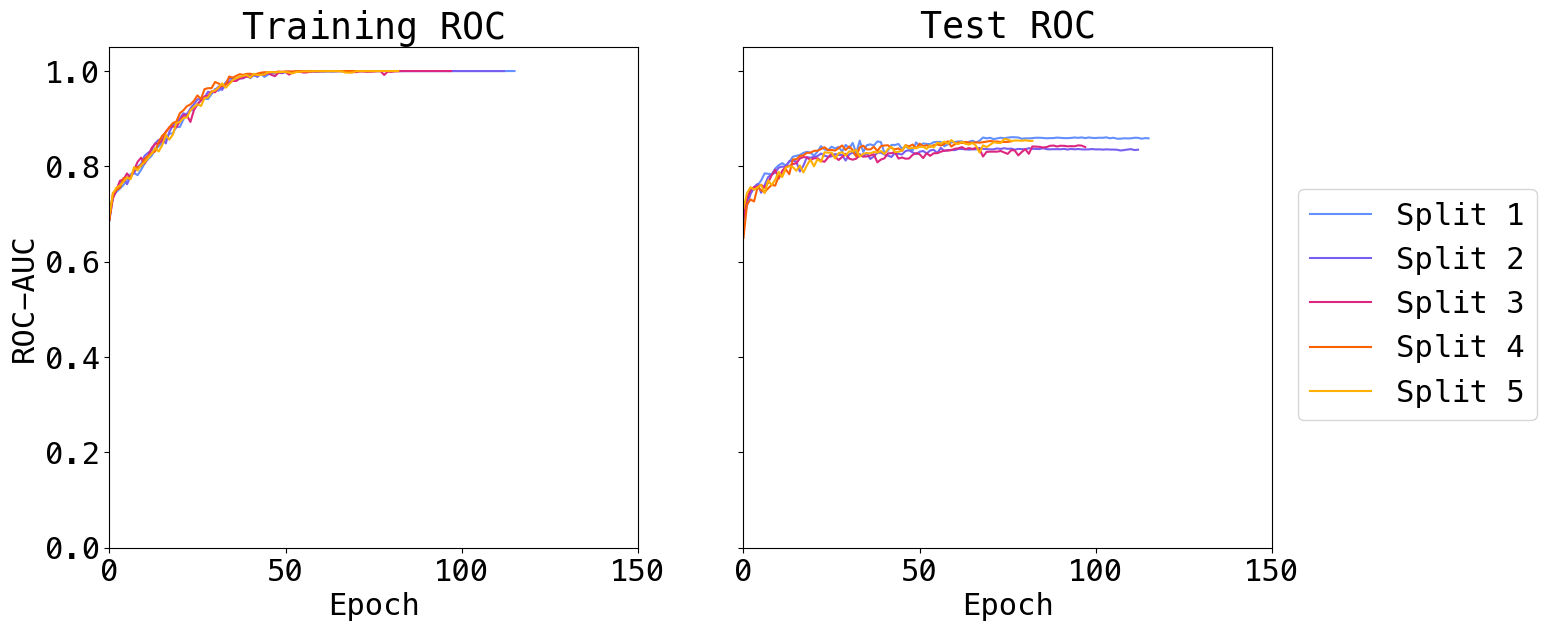

In [19]:
activity_rocs = plot_roc_curves('activity', 5)

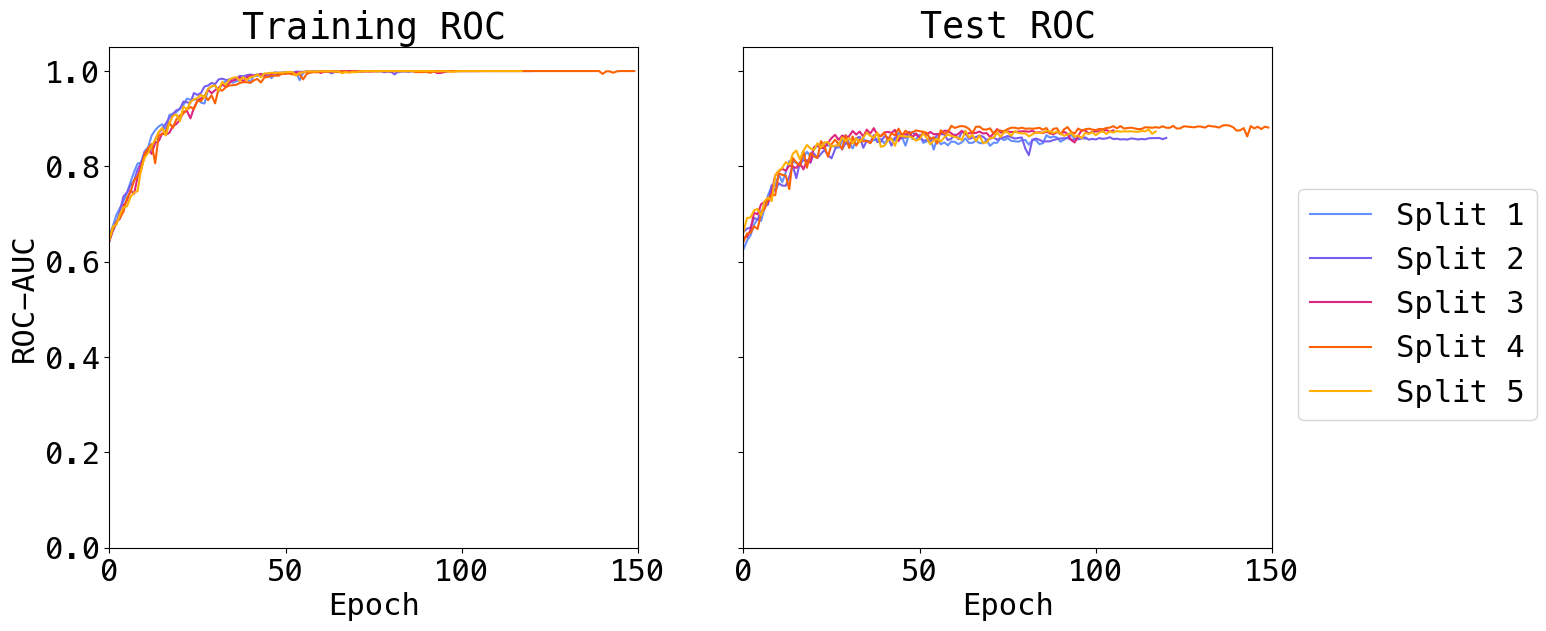

In [20]:
hemolysis_rocs = plot_roc_curves('hemolysis', 5)

Calculate metrics

In [75]:
def predict(model, data_loader):
    
    cat_list = []
    out_list = []

    with torch.no_grad():
        for i_batch, sample_batched in enumerate(data_loader):    
            seq_batched = sample_batched[0][0].to(model.device, non_blocking=True)
            seq_lengths = sample_batched[0][1].to(model.device, non_blocking=True)

            cat_list += sample_batched[1].to("cpu", non_blocking=True)
            out_list += torch.exp(model.evaluate(seq_batched, seq_lengths))[: ,1].to("cpu", non_blocking=True)

        cat_list = torch.stack(cat_list)
        out_list = torch.stack(out_list)
    return cat_list.cpu().numpy().astype(int), out_list.cpu().numpy()

def calculate_metrics(y_true, y_pred, threshold = 0.99205756):
    
    y_pred_converted = y_pred > threshold
    y_pred_converted = y_pred_converted.astype(int)
    
    roc_auc = roc_auc_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred_converted)
    precision = precision_score(y_true, y_pred_converted)
    recall = recall_score(y_true, y_pred_converted)
    f1 = f1_score(y_true, y_pred_converted)
    
    return pd.DataFrame({'roc_auc': [roc_auc], 'accuracy': [accuracy], 'precision': [precision], 'recall': [recall], 'f1': [f1]})

def evaluate_models(df, path, n_splits, vocabulary, threshold):

    df_out = pd.DataFrame()
    filenames = determine_best_models(path, n_splits)

    for i in range(1, n_splits+1):

        test = Dataset(df[df[f'split_{i}'] == 'test'], vocabulary)
        dataloader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False, collate_fn = collate_fn, drop_last=True, pin_memory=True, num_workers=4)

        model = Classifier.load_from_file(filenames[i-1])
        model.to(device)
        
        y_true, y_pred = predict(model, dataloader)
        row = calculate_metrics(y_true, y_pred, threshold)

        df_out = pd.concat([df_out, row], ignore_index=True)
    
    df_out = pd.concat([df_out, pd.DataFrame(df_out.mean()).T], ignore_index=True)
    df_out = pd.concat([df_out, pd.DataFrame(df_out.std()).T], ignore_index=True)
    df_out.index = [f'fold_{i}' for i in range(1, 6)] + ['mean', 'std']

    return df_out

In [90]:
activity_eval = evaluate_models(activity, 'activity', 5, vocabulary, 0.5)
hemolysis_eval = evaluate_models(hemolysis, 'hemolysis', 5, vocabulary, 0.5)

#### Export data frames

In [95]:
activity_eval.to_csv('results/rnn_activity_5cv.csv')
hemolysis_eval.to_csv('results/rnn_hemolysis_5cv.csv')